In [30]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
import matplotlib.pyplot as plt
import seaborn as sns

import json
import glob
import statistics

import scipy.stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, r2_score
from scipy.special import softmax

In [31]:
path = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior"
output_csv_file = "flanker_class_supervised_results/outputs/test_outputs.csv"

# One model

In [32]:
model_path = "2023-09-25_SFinferior_1/11-45-19_72"

In [33]:
bdd = pd.read_csv(f"{path}/{model_path}/{output_csv_file}", index_col=0)

In [34]:
bdd.head()

,labels,dim1,dim2
ID,,,
100206,1,0.172009,0.805077
102513,0,0.190825,0.773158
103212,0,0.857192,0.132026
105620,1,0.243623,0.689641
107220,0,0.885225,0.112811


In [35]:
bdd[["softmax1", "proba"]] = softmax(bdd[["dim1", "dim2"]], axis=1)
bdd.head()

,labels,dim1,dim2,softmax1,proba
ID,,,,,
100206,1,0.172009,0.805077,0.346815,0.653185
102513,0,0.190825,0.773158,0.358396,0.641604
103212,0,0.857192,0.132026,0.673744,0.326256
105620,1,0.243623,0.689641,0.390308,0.609692
107220,0,0.885225,0.112811,0.684043,0.315957


In [36]:
roc_auc_score(bdd.labels, bdd.proba)

0.5388167388167387

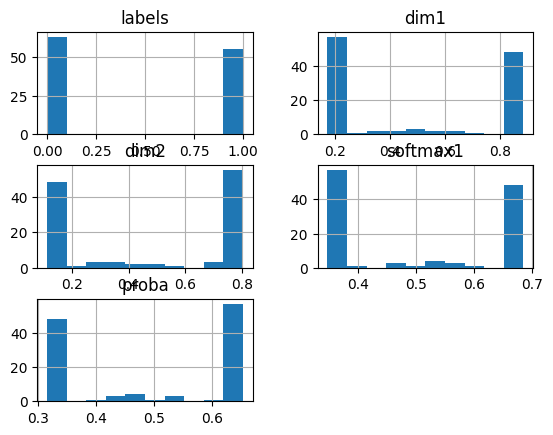

In [37]:
hist = bdd.hist()

<Axes: xlabel='proba', ylabel='Count'>

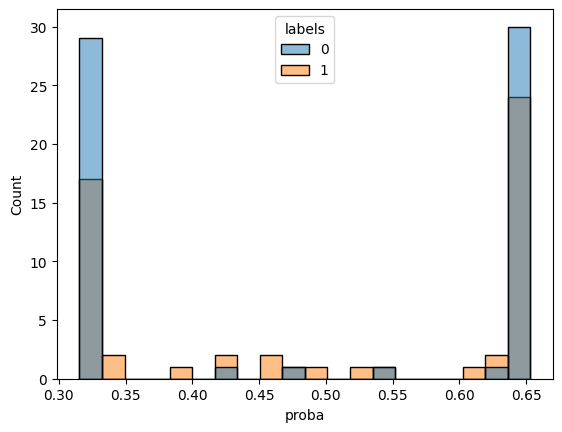

In [38]:
sns.histplot(data=bdd, x="proba", hue="labels", bins=20)

# Ensemble model for SFinferior

In [39]:
bdd = pd.read_csv("/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-25_SFinferior.csv", index_col=0)
bdd = bdd.sort_values(by=['best_test_auc'], ascending=False)
csv_output_file = "flanker_class_supervised_results/outputs/test_outputs.csv"

In [40]:
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss
11,/neurospin/dico/data/deep_folding/history/2023...,0.542464,0.624386,0.623232,0.543087,0.624223,0.623954,0.118628,0.773751,0.001018,138.642960
14,/neurospin/dico/data/deep_folding/history/2023...,0.536747,0.632406,0.514286,0.535523,0.635025,0.622511,0.232445,0.785578,0.001710,138.588120
37,/neurospin/dico/data/deep_folding/history/2023...,0.543695,0.640262,0.618903,0.543906,0.633879,0.618615,0.213467,0.789672,0.001275,138.638351
42,/neurospin/dico/data/deep_folding/history/2023...,0.549765,0.625532,0.611255,0.547962,0.627005,0.615729,0.195508,0.901434,0.001534,138.581528
7,/neurospin/dico/data/deep_folding/history/2023...,0.544161,0.635516,0.618470,0.544634,0.634697,0.615440,0.216597,0.941961,0.000520,138.590683


In [41]:
bdd["criterion"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])
bdd["criterion_end_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
bdd["criterion_end"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
bdd = bdd.sort_values(by=['criterion_end'], ascending=True)
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss,criterion,criterion_end_old,criterion_end
28,/neurospin/dico/data/deep_folding/history/2023...,0.541096,0.649427,0.595815,0.541284,0.652373,0.593362,0.131310,0.759435,0.006698,138.628662,0.806343,0.809476,0.701146
12,/neurospin/dico/data/deep_folding/history/2023...,0.548127,0.648773,0.604618,0.547752,0.645336,0.600000,0.088512,0.972547,0.003687,138.670090,0.806913,0.803100,0.702455
1,/neurospin/dico/data/deep_folding/history/2023...,0.545664,0.648282,0.614141,0.541697,0.646318,0.606349,0.119366,0.773338,0.006838,138.619629,0.811985,0.806055,0.703437
30,/neurospin/dico/data/deep_folding/history/2023...,0.557923,0.645172,0.612121,0.556285,0.648445,0.605772,0.285314,0.917592,0.000498,138.645721,0.795270,0.796906,0.709656
37,/neurospin/dico/data/deep_folding/history/2023...,0.543695,0.640262,0.618903,0.543906,0.633879,0.618615,0.213467,0.789672,0.001275,138.638351,0.822215,0.816043,0.719476


In [42]:
bdd["model_path"].tolist()[:5]

['/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/04-11-11_122',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/19-08-59_124',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/12-19-10_233',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/05-16-46_6',
 '/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/08-58-41_230']

In [43]:
bdd.iloc[0,0]

'/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/04-11-11_122'

In [44]:
output_bdd = pd.DataFrame()
nb_estimators = 5
for i in range(nb_estimators):
    model_path = bdd.iloc[i,0] # takes model_path column
    print(model_path)
    output = pd.read_csv(f"{model_path}/{output_csv_file}", index_col=0)
    if i == 0:
        output_bdd["label"] = output["labels"]
    output[["softmax1", "proba"]] = softmax(output[["dim1", "dim2"]], axis=1)
    output_bdd[f"p{i}"] = output["proba"]
output_bdd["avg"] = output_bdd.iloc[:, 1:(nb_estimators+1)].mean(axis=1)
output_bdd.head()

/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/04-11-11_122
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/19-08-59_124
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-25_SFinferior_1/12-19-10_233
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/05-16-46_6
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/2023-09-25_SFinferior/2023-09-26_SFinferior/08-58-41_230


,label,p0,p1,p2,p3,p4,avg
ID,,,,,,,
100206,1,0.502517,0.497091,0.501183,0.500858,0.501056,0.500541
102513,0,0.502519,0.497098,0.501230,0.501261,0.501051,0.500632
103212,0,0.502524,0.497104,0.501532,0.503644,0.501178,0.501196
105620,1,0.502516,0.497093,0.501140,0.500145,0.501029,0.500385
107220,0,0.502505,0.497067,0.500911,0.498099,0.500914,0.499899


In [45]:
roc_auc_score(output_bdd.label, output_bdd.avg)

0.6164502164502164

In [46]:
auc_bootstrap = []
nb_bootstraps = 1000
for i in range(nb_bootstraps):
    sampling = np.random.choice(range(1, (nb_estimators+1)), size=nb_estimators, replace=True)
    temp = output_bdd.iloc[:,sampling].copy(deep=True)
    temp["label"] = output_bdd["label"]
    temp["avg"] = temp.iloc[:,0:(nb_estimators)].mean(axis=1)
    # print(temp.head())
    auc_bootstrap.append(roc_auc_score(temp.label, temp.avg))
print(auc_bootstrap)

[0.6098124098124098, 0.6152958152958152, 0.6161616161616161, 0.6144300144300144, 0.6121212121212121, 0.615007215007215, 0.6138528138528139, 0.6126984126984127, 0.6138528138528139, 0.6126984126984127, 0.6161616161616162, 0.612987012987013, 0.6129870129870131, 0.6124098124098123, 0.6184704184704185, 0.61010101010101, 0.612987012987013, 0.6132756132756132, 0.6161616161616162, 0.6017316017316018, 0.6126984126984126, 0.61010101010101, 0.6135642135642135, 0.6158730158730159, 0.6135642135642135, 0.6144300144300144, 0.615007215007215, 0.6144300144300144, 0.6167388167388167, 0.6164502164502164, 0.6152958152958152, 0.615007215007215, 0.6121212121212121, 0.6129870129870131, 0.6135642135642135, 0.6118326118326118, 0.6161616161616162, 0.6144300144300144, 0.6126984126984127, 0.6152958152958152, 0.6118326118326118, 0.6132756132756133, 0.6118326118326118, 0.6164502164502164, 0.6144300144300144, 0.6164502164502164, 0.6152958152958152, 0.6135642135642135, 0.6025974025974027, 0.6135642135642135, 0.611832

In [47]:
statistics.stdev(auc_bootstrap)

0.0023636535082121332

(array([  2.,   0.,   0.,   5.,   0.,   9.,   0.,   0.,   0.,   0.,   1.,
         22.,   1., 116., 347., 209., 195.,  79.,  10.,   4.]),
 array([0.595671  , 0.59688312, 0.59809524, 0.59930736, 0.60051948,
        0.6017316 , 0.60294372, 0.60415584, 0.60536797, 0.60658009,
        0.60779221, 0.60900433, 0.61021645, 0.61142857, 0.61264069,
        0.61385281, 0.61506494, 0.61627706, 0.61748918, 0.6187013 ,
        0.61991342]),
 <BarContainer object of 20 artists>)

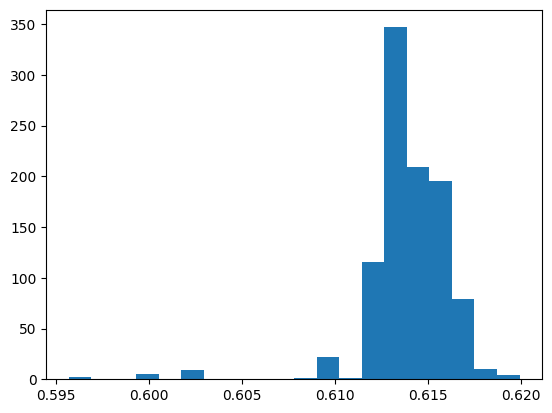

In [48]:
plt.hist(auc_bootstrap, bins=20)

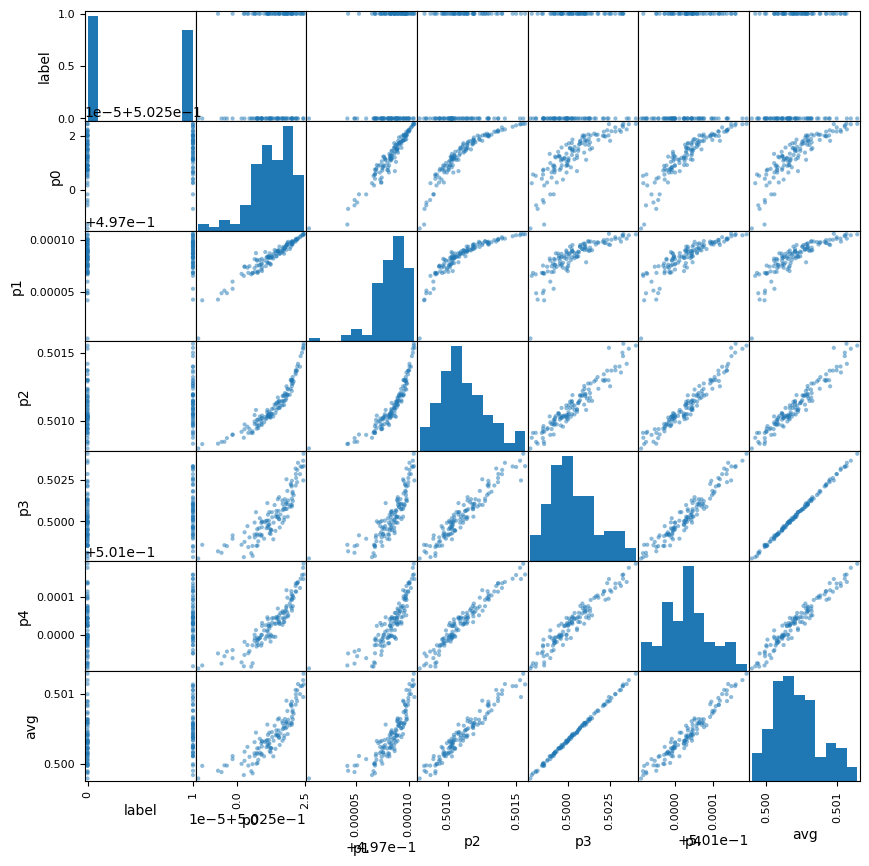

In [49]:
plt_ = pd.plotting.scatter_matrix(output_bdd, figsize=(10,10))

# Putting models together

In [50]:
def confidence_interval(data, percentage=95):
    if percentage == 95:
        z = 1.96
    else:
        raise(ValueError("frero..."))
    
    std = np.std(data)
    N = data.shape[0]

    diff = z * std/np.sqrt(N)

    return diff

In [51]:
json_regions = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Input/sulci_regions_gridsearch.json"
result_file = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/flanker_per_region_on_HCP.ods" 
bdd_path = "/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary"

In [52]:
with open(json_regions) as f:
    regions = json.load(f)

In [53]:
res = pd.read_excel(result_file)
res = res.rename(columns = {"Region (sulci_region_gridsearch)": "region",
                            "Region name without ‘.’ (for yaml configuration)": "region_simple_name"}).drop(res.columns[2:10], axis=1)
res = res.assign(bdd=None)

res = res.dropna(subset = ['AUC'])
res.head()

,region,region_simple_name,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,std_auc_narrow,AUC-2_narrow,std_auc-2_narrow,bdd
0,CINGULATE.,cingulate,0.559,0.019,0.560,0.019,0.546,0.028,0.553,0.008,0.552,0.008,None
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,0.494,0.023,0.488,0.027,0.488,0.014,NaN,NaN,NaN,NaN,None
2,Sc.Cal.-S.Li.,pericalcarine,0.554,0.032,0.554,0.032,0.535,0.030,NaN,NaN,NaN,NaN,None
3,S.T.s.,STs,0.516,0.041,0.530,0.036,0.516,0.041,NaN,NaN,NaN,NaN,None
4,S.T.s.br.,STs_br,0.468,0.009,0.468,0.009,0.468,0.009,NaN,NaN,NaN,NaN,None


In [54]:
res.region_simple_name.tolist()

['cingulate',
 'BROCA',
 'pericalcarine',
 'STs',
 'STs_br',
 'central',
 'central_precentral',
 'central_postcentral',
 'precentral',
 'postcentral',
 'SOr',
 'SOr_olfactif',
 'FCMpost',
 'SFmedian',
 'SFintermediate',
 'SFinferior',
 'SFinternal',
 'occipito_temporal',
 'occipital',
 'intraparietal',
 'internal_parietal',
 'lobule_parietal_sup',
 'inferior_temporal',
 'fissure_collateral',
 'fissure_lateral',
 'fissure_parieto_occipital',
 'fronto-parietal_medial_face']

# Loop over bdd

In [55]:
def return_bdd(region_simple_name):
    csv_file = glob.glob(f"{bdd_path}/bdd_*{region_simple_name}.csv")
    if len(csv_file):
        print(csv_file[0])
        return pd.read_csv(csv_file[0], index_col=0)
    else: 
        print(f"{region_simple_name} without csv")
        return pd.DataFrame()

In [56]:
def compute_logp(auc, std_auc):
    p = scipy.stats.ttest_ind_from_stats(mean1=auc, 
                              std1=std_auc, 
                              nobs1=5, 
                              mean2=0.5, 
                              std2=0, 
                              nobs2=2, 
                              alternative='greater',
                              equal_var=False)[1]
    return -np.log10(p)

In [57]:
def process_bdd(row):

    print(row.bdd)
    bdd = row.bdd
    res_d = {}

    if bdd.empty:
        res_d["AUC_criterion"] = np.nan
        res_d['logp_AUC'] = np.nan
        res_d["std_auc_criterion"] = np.nan
        res_d["AUC_old_criterion"] = np.nan
        res_d["std_auc_old_criterion"] = np.nan
        res_d["AUC_best_val"] = np.nan
        res_d["std_auc_best_val"] = np.nan
        res_d["AUC_best_model"] = np.nan
        res_d["std_auc_best_model"] = np.nan
        res_d['log_lr'] = np.nan
        res_d['std_log_lr'] = np.nan
    else:
        res_d["AUC_criterion"] = np.nan
        res_d['logp_AUC'] = np.nan
        res_d["std_auc_criterion"] = np.nan
        res_d["AUC_old_criterion"] = np.nan
        res_d["std_auc_old_criterion"] = np.nan
        res_d["AUC_best_val"] = np.nan
        res_d["std_auc_best_val"] = np.nan
        res_d["AUC_best_model"] = np.nan
        res_d["std_auc_best_model"] = np.nan
        res_d['log_lr'] = np.nan
        res_d['std_log_lr'] = np.nan
        # Compute criterions
        bdd["criterion"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
        bdd["criterion_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
        bdd["criterion_best"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])

        # Make bdds rearranged according to criterion
        best_end = bdd.sort_values(by=['criterion'], ascending=True)[:5]
        best_end_old = bdd.sort_values(by=['criterion_old'], ascending=True)[:5]
        best_val_end = bdd.sort_values(by=['val_auc'], ascending=False)[:5]
        best_best = bdd.sort_values(by=['criterion_best'], ascending=True)[:5]


        # Compute AUCs
        res_d["AUC_criterion"] = best_end['test_auc'].mean()
        res_d["std_auc_criterion"] = best_end['test_auc'].std()
        res_d['logp_AUC_criterion'] = compute_logp(res_d["AUC_criterion"], res_d["std_auc_criterion"])
        res_d["AUC_old_criterion"] = best_end_old['test_auc'].mean()
        res_d["std_auc_old_criterion"] = best_end_old['test_auc'].std()
        res_d['logp_AUC_old_criterion'] = compute_logp(res_d["AUC_old_criterion"], res_d["std_auc_old_criterion"])
        res_d["AUC_best_val"] = best_val_end['test_auc'].mean()
        res_d["std_auc_best_val"] = best_val_end['test_auc'].std()
        res_d['logp_AUC_best_val'] = compute_logp(res_d["AUC_best_val"], res_d["std_auc_best_val"])
        res_d["AUC_best_model"] = best_best['best_test_auc'].mean()
        res_d["std_auc_best_model"] = best_best['best_test_auc'].std()
        res_d['logp_AUC_best_model'] = compute_logp(res_d["AUC_best_model"], res_d["std_auc_best_model"])
        res_d["log_lr"] = (-np.log10(best_end['lr'])).mean()
        res_d["std_log_lr"] = (-np.log10(best_end['lr'])).std()


    return pd.Series(res_d)

In [58]:
res["bdd"] = res["region_simple_name"].apply(return_bdd)

/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-11_cingulate.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-12_BROCA.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-21_pericalcarine.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-20_STs.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-27_STs_br.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-26_central.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-14_central_precentral.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-19_central_postcentral.csv
/neurospin/dico/data/deep_folding/history/2023-09_joel-flanker/Output/summary/bdd_2023-09-28_precentral.csv
/neurospin/dico/data/deep_fo

In [59]:
res = res.join(res.apply(process_bdd, axis="columns"))


                                           model_path  train_auc   val_auc  \
0   /neurospin/dico/data/deep_folding/history/2023...   0.992984  0.653191   
1   /neurospin/dico/data/deep_folding/history/2023...   0.557359  0.588707   
2   /neurospin/dico/data/deep_folding/history/2023...   0.599898  0.607856   
3   /neurospin/dico/data/deep_folding/history/2023...   1.000000  0.621604   
4   /neurospin/dico/data/deep_folding/history/2023...   0.998265  0.615712   
..                                                ...        ...       ...   
36  /neurospin/dico/data/deep_folding/history/2023...   0.662320  0.547954   
37  /neurospin/dico/data/deep_folding/history/2023...   0.541615  0.516039   
38  /neurospin/dico/data/deep_folding/history/2023...   0.500000  0.500000   
39  /neurospin/dico/data/deep_folding/history/2023...   0.580322  0.576432   
40  /neurospin/dico/data/deep_folding/history/2023...   0.996717  0.620622   

    test_auc  best_train_auc  best_val_auc  best_test_auc  drop

In [60]:
res.head()

,region,region_simple_name,AUC,std_auc,AUC-1,std_auc-1,AUC-2,std_auc-2,AUC_narrow,std_auc_narrow,...,AUC_best_val,std_auc_best_val,AUC_best_model,std_auc_best_model,log_lr,std_log_lr,logp_AUC_criterion,logp_AUC_old_criterion,logp_AUC_best_val,logp_AUC_best_model
0,CINGULATE.,cingulate,0.559,0.019,0.560,0.019,0.546,0.028,0.553,0.008,...,0.546378,0.027564,0.561097,0.039295,2.653998,0.434632,2.970499,2.970499,2.005764,1.895694
1,S.F.inf.-BROCA-S.Pe.C.inf.,BROCA,0.494,0.023,0.488,0.027,0.488,0.014,NaN,NaN,...,0.487792,0.013850,0.508369,0.024027,2.386500,0.193476,0.153070,0.092444,0.026882,0.620193
2,Sc.Cal.-S.Li.,pericalcarine,0.554,0.032,0.554,0.032,0.535,0.030,NaN,NaN,...,0.535296,0.030075,0.560029,0.028885,2.547291,0.483520,2.002862,2.002862,1.533586,2.315037
3,S.T.s.,STs,0.516,0.041,0.530,0.036,0.516,0.041,NaN,NaN,...,0.516248,0.040687,0.515556,0.041121,3.205652,0.280429,0.675366,1.243215,0.675366,0.652422
4,S.T.s.br.,STs_br,0.468,0.009,0.468,0.009,0.468,0.009,NaN,NaN,...,0.468341,0.009148,0.482482,0.031245,3.000318,0.329289,0.000326,0.000326,0.000326,0.065055


/tmp/ipykernel_1699044/2997021409.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(res.region_simple_name, res.log_lr, res.std_log_lr, fmt='.', marker='o')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, 'cingulate'),
  Text(1, 0, 'BROCA'),
  Text(2, 0, 'pericalcarine'),
  Text(3, 0, 'STs'),
  Text(4, 0, 'STs_br'),
  Text(5, 0, 'central'),
  Text(6, 0, 'central_precentral'),
  Text(7, 0, 'central_postcentral'),
  Text(8, 0, 'precentral'),
  Text(9, 0, 'postcentral'),
  Text(10, 0, 'SOr'),
  Text(11, 0, 'SOr_olfactif'),
  Text(12, 0, 'FCMpost'),
  Text(13, 0, 'SFmedian'),
  Text(14, 0, 'SFintermediate'),
  Text(15, 0, 'SFinferior'),
  Text(16, 0, 'SFinternal'),
  Text(17, 0, 'occipito_temporal'),
  Text(18, 0, 'occipital'),
  Text(19, 0, 'intraparietal'),
  Text(20, 0, 'internal_parietal'),
  Text(21, 0, 'lobule_parietal_sup'),
  Text(22, 0, 'inferior_temporal'),
  Text(23, 0, 'fissure_collateral'),
  Text(24, 0, 'fissure_lateral'),
  Text(25, 0, 'fissure_parieto_occipital'),
  Text(26, 0, 'fronto-parietal_medial_face')])

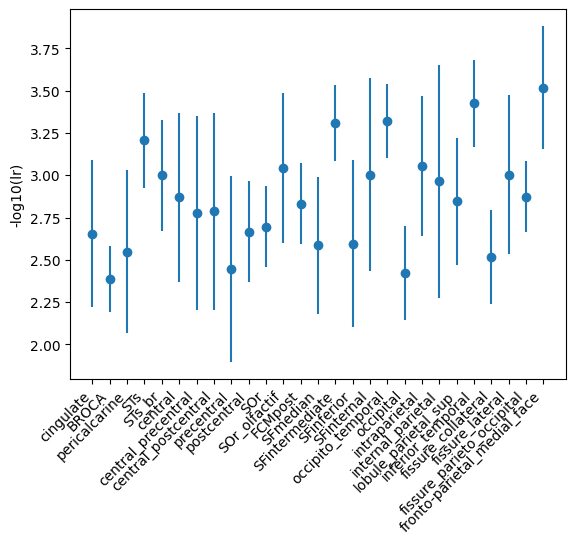

In [61]:
plt.errorbar(res.region_simple_name, res.log_lr, res.std_log_lr, fmt='.', marker='o')
plt.ylabel("-log10(lr)")
plt.xticks(rotation=45, ha="right")

Text(0, 0.5, 'AUC')

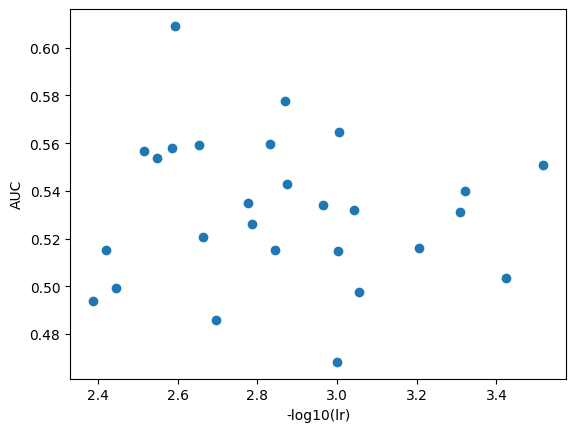

In [62]:
plt.scatter(res.log_lr, res.AUC_criterion)
plt.xlabel("-log10(lr)")
plt.ylabel("AUC")

In [63]:
res.logp_AUC

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
Name: logp_AUC, Length: 27, dtype: float64

In [64]:
def plot_manhattan(res, region_name, ax, AUC_name, logp_AUC_name):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)

    print(res.columns)
    
    res["line"] = 1.3
    markerline, stemlines, baseline = \
        ax.stem(res[region_name],
              res[logp_AUC_name],
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    plt.xticks(rotation=45, ha="right")
    ax.plot(res[region_name], res.line, c='black')
    ax.set_ylabel("-log10(p)", labelpad=3.0)
    # ax.set_xlabel("regions", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(res[region_name], res[AUC_name], c='blue')
    ax2.set_ylim([0.48,0.66])
    ax2.set_ylabel('AUC', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0.5, 0.55, 0.6, 0.65])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(0.46)


Index(['region', 'region_simple_name', 'AUC', 'std_auc', 'AUC-1', 'std_auc-1',
       'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow', 'AUC-2_narrow',
       'std_auc-2_narrow', 'bdd', 'AUC_criterion', 'logp_AUC',
       'std_auc_criterion', 'AUC_old_criterion', 'std_auc_old_criterion',
       'AUC_best_val', 'std_auc_best_val', 'AUC_best_model',
       'std_auc_best_model', 'log_lr', 'std_log_lr', 'logp_AUC_criterion',
       'logp_AUC_old_criterion', 'logp_AUC_best_val', 'logp_AUC_best_model'],
      dtype='object')


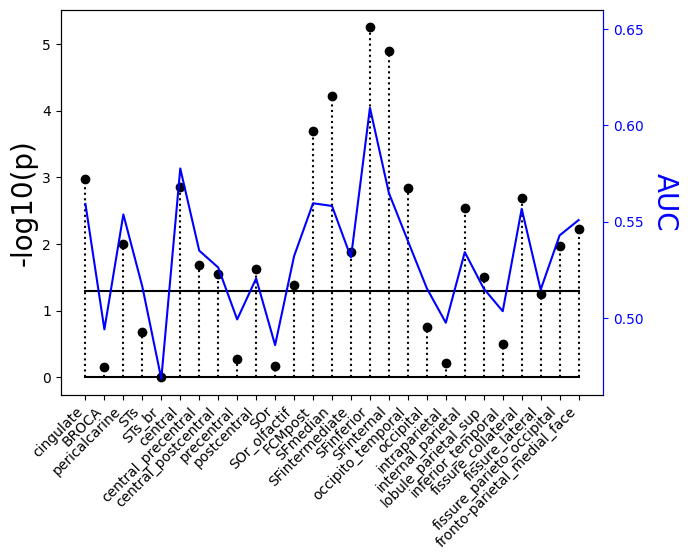

In [65]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region_simple_name", ax, "AUC_criterion", "logp_AUC_criterion")
plt.show()

Index(['region', 'region_simple_name', 'AUC', 'std_auc', 'AUC-1', 'std_auc-1',
       'AUC-2', 'std_auc-2', 'AUC_narrow', 'std_auc_narrow', 'AUC-2_narrow',
       'std_auc-2_narrow', 'bdd', 'AUC_criterion', 'logp_AUC',
       'std_auc_criterion', 'AUC_old_criterion', 'std_auc_old_criterion',
       'AUC_best_val', 'std_auc_best_val', 'AUC_best_model',
       'std_auc_best_model', 'log_lr', 'std_log_lr', 'logp_AUC_criterion',
       'logp_AUC_old_criterion', 'logp_AUC_best_val', 'logp_AUC_best_model',
       'line'],
      dtype='object')


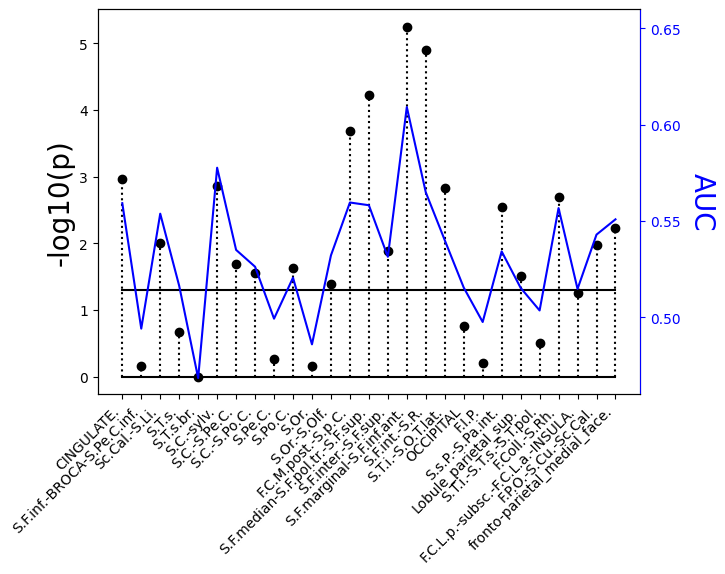

In [66]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_manhattan(res, "region", ax, "AUC_criterion", "logp_AUC_criterion")
plt.show()

# bdd

In [67]:
bdd = pd.read_csv("/neurospin/dico/jchavas/Runs/61_classifier_regresser/Output/flanker/summary/bdd_2023-09-26_inferior_temporal.csv", index_col=0)
bdd = bdd.sort_values(by=['best_test_auc'], ascending=False)

In [68]:
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss
9,/home_local/jc225751/Runs/61_classifier_regres...,0.464740,0.473650,0.501443,0.557953,0.621440,0.532468,0.139103,0.992356,0.006592,138.673721
4,/home_local/jc225751/Runs/61_classifier_regres...,0.626189,0.677905,0.532179,0.621787,0.676923,0.531025,0.286876,0.850695,0.000102,138.452469
5,/home_local/jc225751/Runs/61_classifier_regres...,0.611398,0.524714,0.517172,0.565051,0.630769,0.527850,0.071892,0.736797,0.000510,138.398804
30,/home_local/jc225751/Runs/61_classifier_regres...,0.823671,0.589853,0.534199,0.603511,0.665794,0.524531,0.075156,0.838581,0.000351,131.535904
3,/home_local/jc225751/Runs/61_classifier_regres...,0.688971,0.526678,0.485137,0.621937,0.668412,0.522367,0.163359,0.708882,0.000166,137.460846


AUC = 0.5034632034632034 +/- 0.014712247158412475
AUC-1 = 0.4979797979797979 +/- 0.019979708560614897
AUC-2 = 0.5034632034632034 +/- 0.014712247158412475
AUC (best model) = 0.4868398268398268 +/- 0.011782528717717053


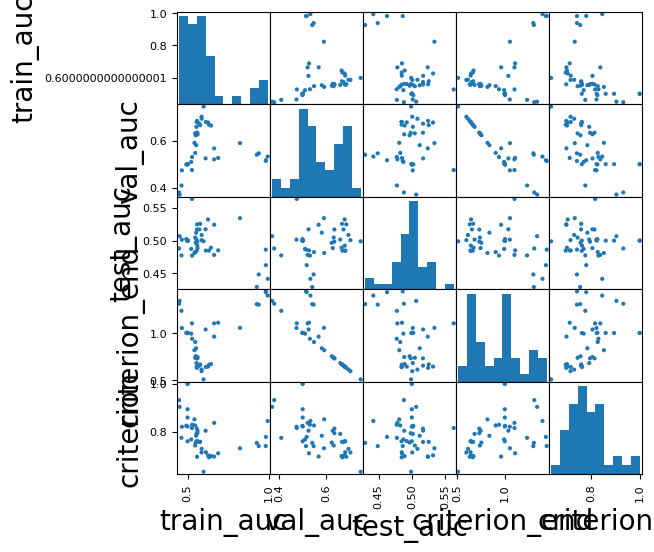

In [69]:
bdd["criterion"] = abs(bdd["best_val_auc"] - bdd["best_train_auc"]) + 2*(1-bdd["best_val_auc"])
bdd["criterion_end_old"] = abs(bdd["val_auc"] - bdd["train_auc"]) + 2*(1-bdd["val_auc"])
bdd["criterion_end"] = bdd.apply(lambda x: 2*(1-x["val_auc"]) + max(-x["val_auc"] + x["train_auc"], 0), axis=1)
best_end = bdd.sort_values(by=['criterion_end'], ascending=True)[:5]
best_end_old = bdd.sort_values(by=['criterion_end_old'], ascending=True)[:5]
best_val_end = bdd.sort_values(by=['val_auc'], ascending=False)[:5]
best_best = bdd.sort_values(by=['criterion'], ascending=True)[:5]
print(f"AUC = {best_end['test_auc'].mean()} +/- {best_end['test_auc'].std()}")
print(f"AUC-1 = {best_end_old['test_auc'].mean()} +/- {best_end_old['test_auc'].std()}")
print(f"AUC-2 = {best_val_end['test_auc'].mean()} +/- {best_val_end['test_auc'].std()}")
print(f"AUC (best model) = {best_best['best_test_auc'].mean()} +/- {best_best['best_test_auc'].std()}")
obj = pd.plotting.scatter_matrix(bdd[['train_auc', 'val_auc', 'test_auc', 'criterion_end', 'criterion']],
                                 figsize=(6,6),
                                 alpha=1.0)

In [70]:
bdd = bdd.sort_values(by=['criterion_end'], ascending=True)
bdd.head()

,model_path,train_auc,val_auc,test_auc,best_train_auc,best_val_auc,best_test_auc,drop_rate,gamma,lr,train_loss,criterion,criterion_end_old,criterion_end
36,/home_local/jc225751/Runs/61_classifier_regres...,0.598809,0.745827,0.498990,0.606531,0.760884,0.491631,0.124402,0.894893,0.000229,138.630814,0.632586,0.655365,0.508347
41,/home_local/jc225751/Runs/61_classifier_regres...,0.586309,0.702455,0.500722,0.585460,0.701473,0.496392,0.254461,0.794546,0.000321,138.583435,0.713067,0.711236,0.595090
32,/home_local/jc225751/Runs/61_classifier_regres...,0.587068,0.693944,0.508514,0.586287,0.685434,0.513997,0.217545,0.875238,0.000247,138.776733,0.728280,0.718988,0.612111
18,/home_local/jc225751/Runs/61_classifier_regres...,0.558944,0.684779,0.524675,0.604262,0.700491,0.466955,0.239622,0.898063,0.000417,138.457809,0.695247,0.756277,0.630442
17,/home_local/jc225751/Runs/61_classifier_regres...,0.556052,0.680360,0.484416,0.557547,0.682488,0.481097,0.239798,0.867935,0.000988,138.769058,0.759965,0.763588,0.639280


Text(0, 0.5, 'best_test_auc')

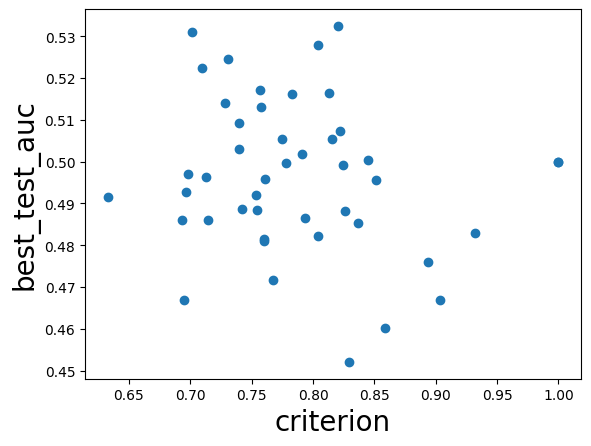

In [71]:
plt.scatter(bdd["criterion"], bdd.best_test_auc)
plt.xlabel("criterion")
plt.ylabel("best_test_auc")

Text(0, 0.5, 'test_auc')

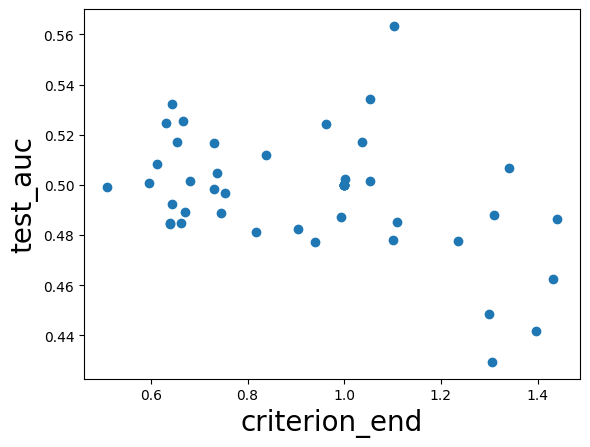

In [72]:
plt.scatter(bdd["criterion_end"], bdd.test_auc)
plt.xlabel("criterion_end")
plt.ylabel("test_auc")
# plt.xlim((0.75,0.85))

Text(0, 0.5, 'val_auc')

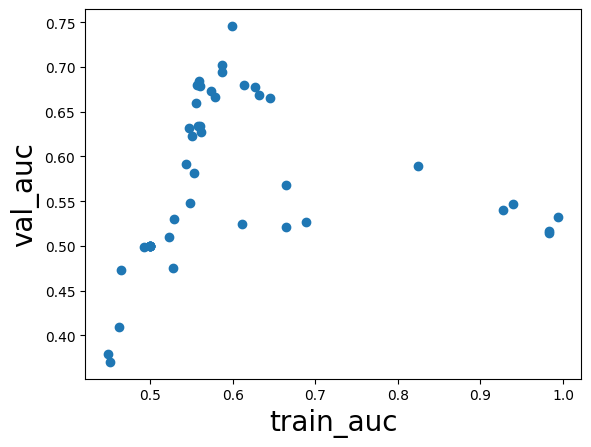

In [73]:
plt.scatter(bdd.train_auc, bdd.val_auc)
plt.xlabel("train_auc")
plt.ylabel("val_auc")

Text(0, 0.5, 'criterion')

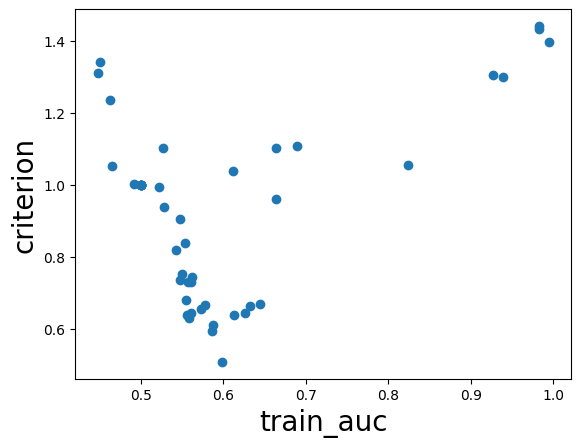

In [74]:
plt.scatter(bdd.train_auc, bdd.criterion_end)
plt.xlabel("train_auc")
plt.ylabel("criterion")

Text(0, 0.5, 'test_auc')

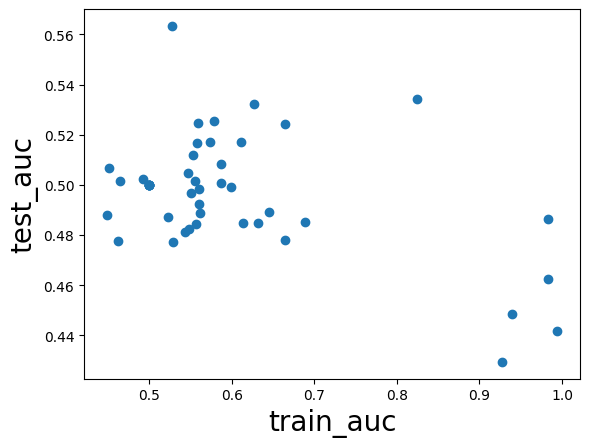

In [75]:
plt.scatter(bdd.train_auc, bdd.test_auc)
plt.xlabel("train_auc")
plt.ylabel("test_auc")

Text(0, 0.5, 'test_auc')

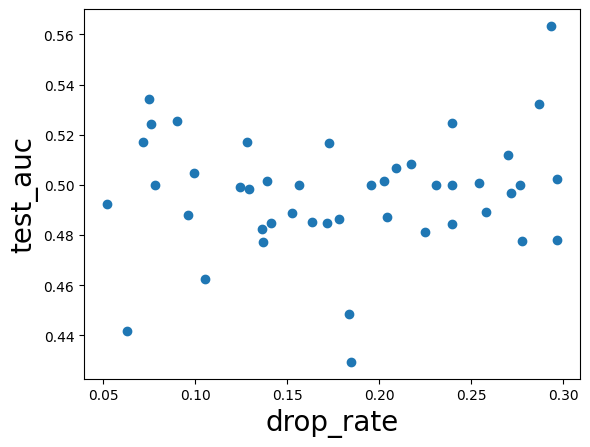

In [76]:
plt.scatter(bdd.drop_rate, bdd.test_auc)
plt.xlabel("drop_rate")
# plt.xscale("log")
plt.ylabel("test_auc")
# plt.xlim((0.75,0.85))

Text(0, 0.5, 'test_auc')

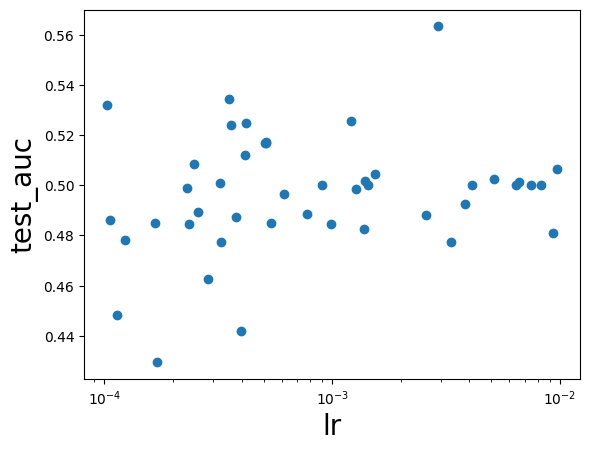

In [77]:
plt.scatter(bdd.lr, bdd.test_auc)
plt.xlabel("lr")
plt.xscale("log")
plt.ylabel("test_auc")
# plt.xlim((0.75,0.85))

(0.7, 0.85)

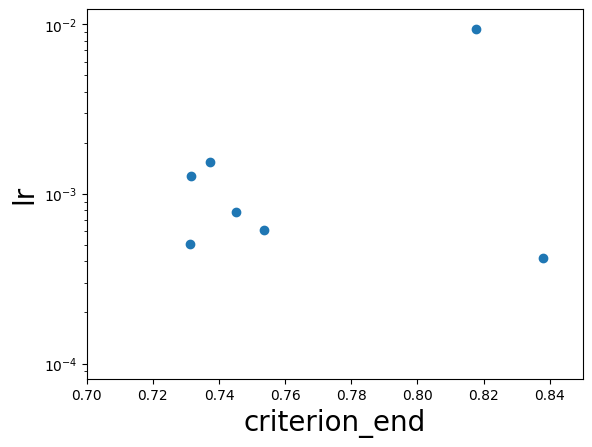

In [78]:
plt.scatter(bdd["criterion_end"], bdd.lr)
plt.xlabel("criterion_end")
plt.ylabel("lr")
plt.yscale("log")
plt.xlim((0.7,0.85))

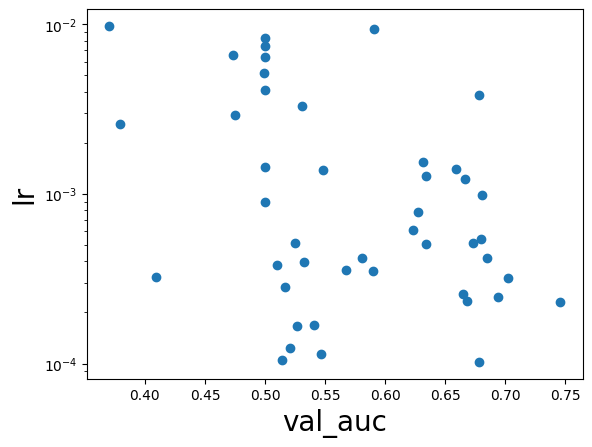

In [79]:
plt.scatter(bdd["val_auc"], bdd.lr)
plt.xlabel("val_auc")
plt.ylabel("lr")
plt.yscale("log")

(0.7, 0.85)

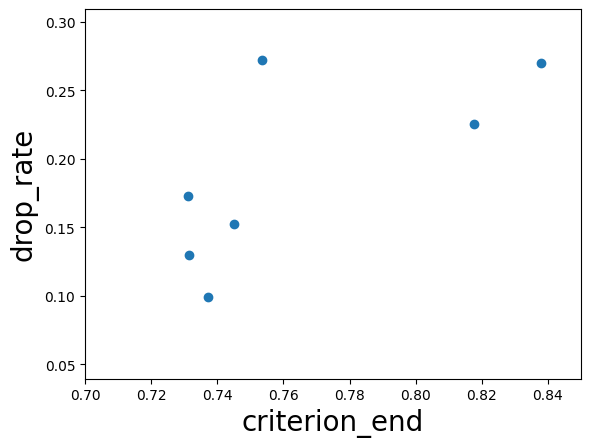

In [80]:
plt.scatter(bdd["criterion_end"], bdd.drop_rate)
plt.xlabel("criterion_end")
plt.ylabel("drop_rate")
# plt.yscale("log")
plt.xlim((0.7,0.85))

In [81]:
quantile = []
test_auc = []
test_auc_cum = []
error_cum = []
error = []
delta=0.1
quantile_x = np.arange(delta,1+delta,delta)
print(quantile_x)
for q in quantile_x:
    one_quantile = bdd['criterion_end'].quantile(q=q)
    quantile.append(one_quantile)
    test_auc_cum.append(bdd[bdd['criterion_end'] < one_quantile]['test_auc'].mean())
    error_cum.append(bdd[bdd['criterion_end'] < one_quantile]['test_auc'].sem())
    if q==delta:
        test_auc.append(test_auc_cum[-1])
        error.append(error_cum[-1])
    else:
        test_auc.append(bdd[(bdd['criterion_end'] < one_quantile) & (bdd['criterion_end'] >= quantile[-2])]['test_auc'].mean())
        error.append(bdd[(bdd['criterion_end'] < one_quantile) & (bdd['criterion_end'] >= quantile[-2])]['test_auc'].sem())

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [82]:
test_auc

[0.5034632034632034,
 0.5066017316017316,
 0.5035786435786436,
 0.4970779220779222,
 0.48820346320346314,
 0.5056998556998558,
 0.5003298289012574,
 0.5188744588744589,
 0.46013708513708507,
 0.47478354978354975]

In [83]:
error

[0.006579516949597682,
 0.010951195022363983,
 0.007832507621055348,
 0.003299699234270354,
 0.008004296399939393,
 0.01839826839826844,
 0.00032982890125746574,
 0.014444754376494246,
 0.012923979224640376,
 0.014208542731427331]

Text(0, 0.5, 'test_auc')

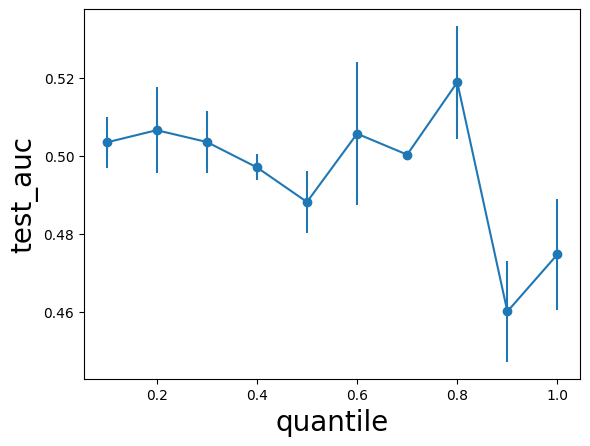

In [84]:
plt.errorbar(quantile_x, test_auc, error, marker='o')
plt.xlabel("quantile")
plt.ylabel("test_auc")
# plt.ylim((0.45,0.6))

(0.45, 0.6)

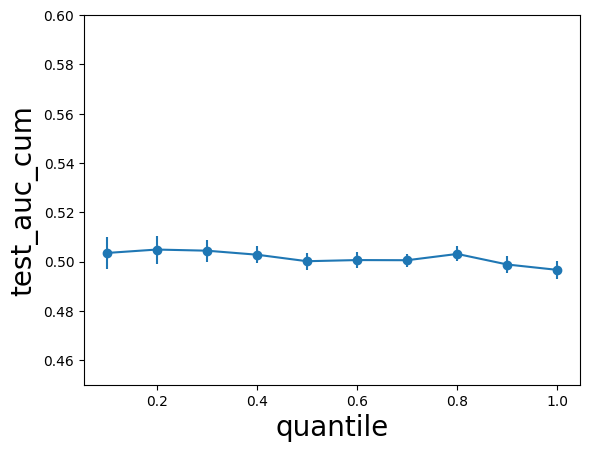

In [85]:
plt.errorbar(quantile_x, test_auc_cum, error_cum, marker='o')
plt.xlabel("quantile")
plt.ylabel("test_auc_cum")
plt.ylim((0.45,0.6))

Text(0, 0.5, 'test_auc')

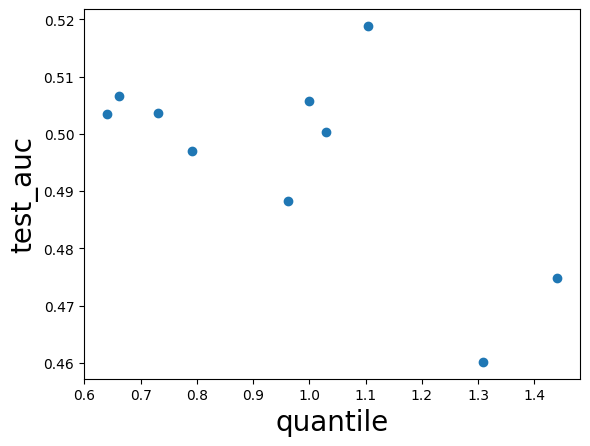

In [86]:
plt.scatter(quantile, test_auc)
plt.xlabel("quantile")
plt.ylabel("test_auc")

In [87]:
best_quantile = []
best_test_auc = []
for q in quantile_x:
    one_quantile = bdd['criterion'].quantile(q=q)
    best_quantile.append(one_quantile)
    best_test_auc.append(bdd[bdd['criterion'] < one_quantile]['best_test_auc'].mean())

Text(0, 0.5, 'best_test_auc')

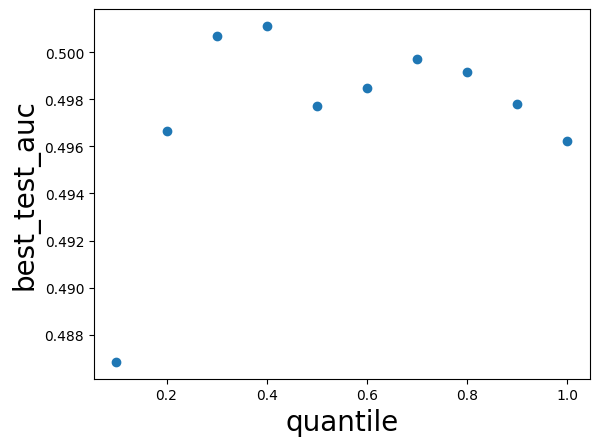

In [88]:
plt.scatter(quantile_x, best_test_auc)
plt.xlabel("quantile")
plt.ylabel("best_test_auc")

Text(0, 0.5, 'test_auc')

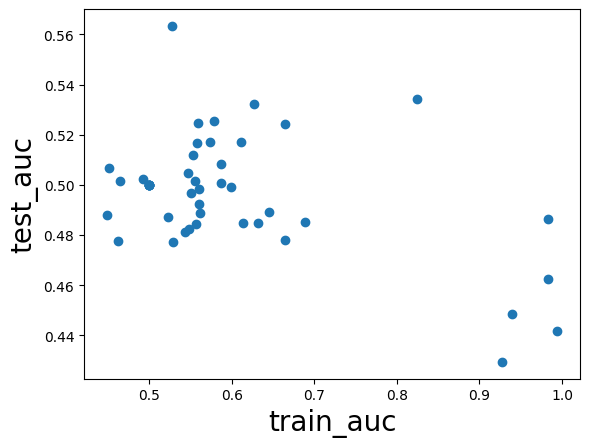

In [89]:
plt.scatter(bdd.train_auc, bdd.test_auc)
plt.xlabel("train_auc")
plt.ylabel("test_auc")

Text(0, 0.5, 'test_auc')

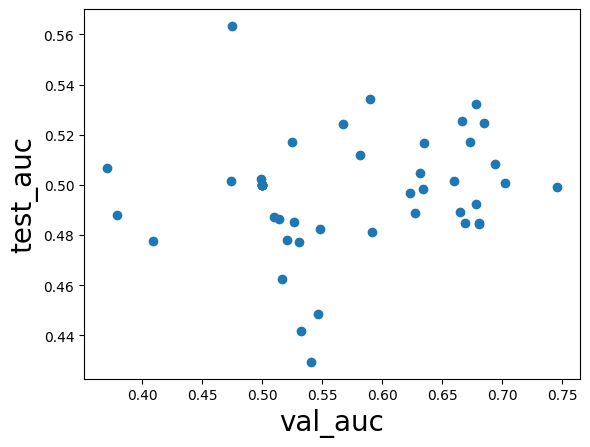

In [90]:
plt.scatter(bdd.val_auc, bdd.test_auc)
plt.xlabel("val_auc")
plt.ylabel("test_auc")

Text(0, 0.5, 'criterion')

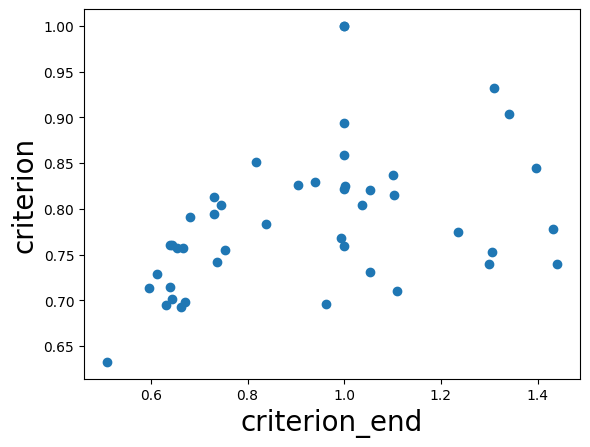

In [91]:
plt.scatter(bdd.criterion_end, bdd.criterion)
plt.xlabel("criterion_end")
plt.ylabel("criterion")

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

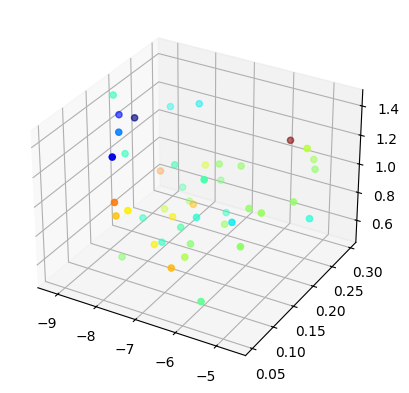

In [92]:
import matplotlib.cm as cmx
import matplotlib
colorsMap = 'jet'
cm = plt.get_cmap(colorsMap)
cs = bdd.test_auc
z = bdd.criterion_end
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
scat = ax.scatter(np.log(bdd.lr), bdd.drop_rate, z, c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
fig.colorbar(scalarMap)

In [ ]:
import matplotlib.cm as cmx
import matplotlib
colorsMap = 'jet'
cm = plt.get_cmap(colorsMap)
cs = bdd.test_auc
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1)
scat = ax.scatter(bdd.lr, bdd.drop_rate, c=scalarMap.to_rgba(cs))
ax.set_xscale("log")
scalarMap.set_array(cs)
fig.colorbar(scalarMap)

In [ ]:
import matplotlib.cm as cmx
import matplotlib
colorsMap = 'jet_r'
cm = plt.get_cmap(colorsMap)
cs = bdd.criterion_end
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1)
scat = ax.scatter(bdd.lr, bdd.drop_rate, c=scalarMap.to_rgba(cs))
ax.set_xscale("log")
scalarMap.set_array(cs)
fig.colorbar(scalarMap)

In [ ]:
plt.scatter(bdd.train_auc, bdd.val_auc)
plt.xlabel("train_auc")
plt.ylabel("val_auc")

In [ ]:
bdd.sort_values(by=['criterion_end'], ascending=True)